# Train a regression ConvNN model

In [1]:
import sys  
sys.path.insert(0, '../telescopeML/')

from DeepRegBuilder import *
from StatVisAnalyzer import regression_report

Loading BokehJS ...

# Step 1: Load the training dataset (syntheric spectra)

In [3]:
# original trainign dataset astronomers use to predict the parameters of the telescope brown dwarf spectra

train_BD = pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2.csv.bz2', compression='bz2')
train_BD.head(3)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


### Check the columns
note: one of the columns, *is_augmented*, is indicating wheter this is a native dataset or an augmented one. For now, we don't need it so drop it, but all modules will take this into account! 

In [4]:
target_features = ['gravity', 'temperature', 'c_o_ratio', 'metallicity']
train_BD[target_features].head()

,gravity,temperature,c_o_ratio,metallicity
0,5.0,1100,0.25,-1.0
1,5.0,1100,0.25,-0.7
2,5.0,1100,0.25,-0.5
3,5.0,1100,0.25,-0.3
4,5.0,1100,0.25,0.0


In [5]:
training_features_labels = [item for item in train_BD.columns.to_list() if item not in target_features+['is_augmented']]
training_features_labels[:5]

['2.512', '2.487', '2.462', '2.438', '2.413']

In [6]:
wl = pd.read_csv('../../datasets/wl.csv')
wl.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


## Prepare feature variables (X) and targets (y)

In [7]:
# to assure we are only training the module with the native non-augmented BD training dataset
train_BD = train_BD[train_BD['is_augmented'].isin(['no'])] 


# Training feature variables
X = train_BD.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)


# Target feature variables
y = train_BD[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


In [8]:
y.loc[:, 'temperature'] = np.log10(y['temperature'])

/var/folders/30/n2yd25m90v1bywy0rcgx4fqc0000gq/T/ipykernel_56350/1983952283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[:, 'temperature'] = np.log10(y['temperature'])


In [9]:
y.head(5)

,gravity,c_o_ratio,metallicity,temperature
0,5.0,0.25,-1.0,3.041393
1,5.0,0.25,-0.7,3.041393
2,5.0,0.25,-0.5,3.041393
3,5.0,0.25,-0.3,3.041393
4,5.0,0.25,0.0,3.041393


---

# Step 2: Build the CNN model / Data processing

In [10]:
# Instintiate TrainCNNRegression class
train_cnn_regression = TrainRegression(feature_values=X.to_numpy(),
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             n_jobs=4,
                             cv=5,
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN')

#### Split the dataset into train, validate and test sets

In [11]:
# Split the dataset into train and test sets
train_cnn_regression.split_train_validation_test(test_size=0.1, val_size=0.1)

In [12]:
# Scale the X features using MinMax Scaler
train_cnn_regression.standardize_X_row_wise()

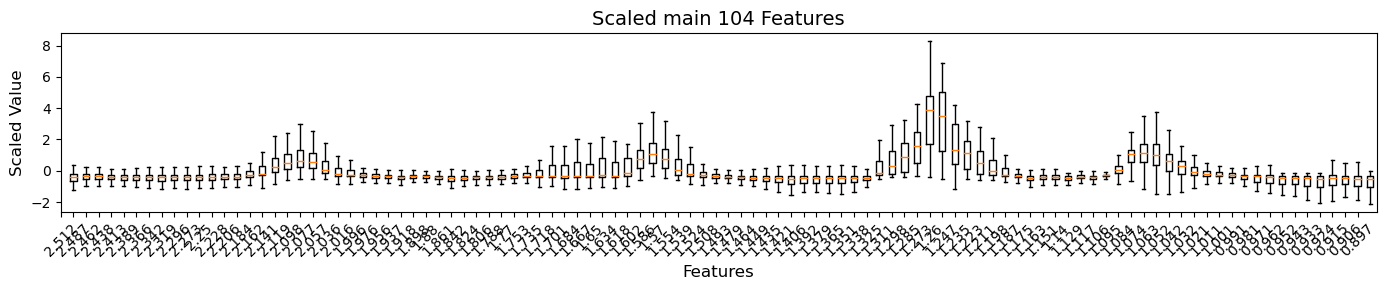

In [13]:
train_cnn_regression.plot_boxplot_scaled_features(scaled_feature= train_cnn_regression.X_train_standardized_rowwise, 
                                                  xticks_list = training_features_labels,
                                                  title = 'Scaled main 104 Features',
                                                  fig_size=(14, 3),
                                                    )

### Scale y features - ColumnWise

In [14]:
# Standardize the y features using Standard Scaler
train_cnn_regression.standardize_y_column_wise()

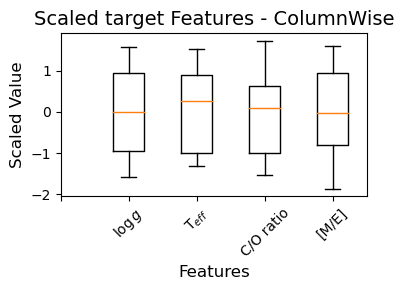

In [15]:
train_cnn_regression.plot_boxplot_scaled_features(scaled_feature= train_cnn_regression.y_train_standardized_columnwise, 
                                                  xticks_list = ['','$\log g$', 'T$_{eff}$', 'C/O ratio', '[M/E]'],
                                                  title = 'Scaled target Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

In [16]:
# train_cnn_regression.y_train_standardized_columnwise

### Feature engeenering: Take Min and Max of each row (BD spectra) 

In [17]:
train_cnn_regression.X_train_min = train_cnn_regression.X_train.min(axis=1)
train_cnn_regression.X_train_max = train_cnn_regression.X_train.max(axis=1)

In [18]:
train_cnn_regression.X_val_min = train_cnn_regression.X_val.min(axis=1)
train_cnn_regression.X_val_max = train_cnn_regression.X_val.max(axis=1)

In [19]:
train_cnn_regression.X_test_min = train_cnn_regression.X_test.min(axis=1)
train_cnn_regression.X_test_max = train_cnn_regression.X_test.max(axis=1)

In [20]:
df_MinMax_train = pd.DataFrame((train_cnn_regression.X_train_min, train_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((train_cnn_regression.X_val_min, train_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((train_cnn_regression.X_test_min, train_cnn_regression.X_test_max)).T

In [21]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [22]:
df_MinMax_train.head()

,min,max
0,8.265340e-12,3.445259e-08
1,8.080712e-22,8.397132e-14
2,2.734403e-07,8.632182e-06
3,4.414951e-16,3.373262e-10
4,3.722576e-07,6.859888e-06


### Scale Min Max features - ColumnWise

In [23]:
train_cnn_regression.standardize_X_column_wise(
                                                X_train = df_MinMax_train.values,
                                                X_val   = df_MinMax_val.values,
                                                X_test  = df_MinMax_test.values,
                                                )

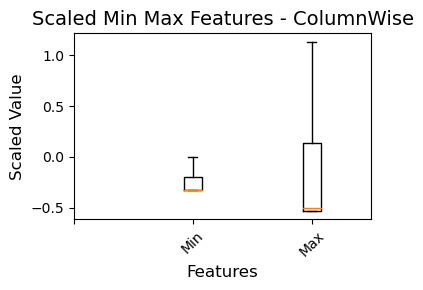

In [24]:
train_cnn_regression.plot_boxplot_scaled_features(scaled_feature= train_cnn_regression.X_test_standardized_columnwise, 
                                                  xticks_list = ['','Min','Max'],
                                                  title = 'Scaled Min Max Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

# Step 3: Train CNN model

In [26]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the model architecture
input_1 = tf.keras.layers.Input(shape=(104, 1))
input_2 = tf.keras.layers.Input(shape=(2,))

model  = Conv1D(32, 3, 
                 kernel_initializer = 'he_normal', 
                 activation='relu', 
                 input_shape=(104, 1))(input_1)

model  = Conv1D(64, 3, 
                kernel_initializer = 'he_normal', 
                activation='relu')(model)

model  = Conv1D(128, 3, 
                kernel_initializer = 'he_normal', 
                activation='relu')(model)

model  = MaxPooling1D(2)(model)

model  = Conv1D(256, 3, 
                kernel_initializer = 'he_normal', 
                activation='relu')(model)

model  = Conv1D(512, 3, 
                kernel_initializer = 'he_normal', 
                activation='relu')(model)


model  = MaxPooling1D(2)(model)
model  = Flatten()(model)

model = tf.keras.layers.concatenate([model, input_2], 
                                                 name = 'Concatenated_Layer')


model  = Dense(128,                      
                kernel_initializer = 'he_normal',
                activation='relu')(model)

model  = Dense(512,                      
                kernel_initializer = 'he_normal',
                activation='relu')(model)

out__gravity =  Dense(1, 
                      activation='linear',
                name='gravity')(model)  # No activation function for regression

out__c_o_ratio = Dense(1, 
                      activation='linear',
                      name='c_o_ratio')(model)  # No activation function for regression

out__metallicity = Dense(1, 
                        activation='linear',
                        name='metallicity')(model)  # No activation function for regression

out__temperature = Dense(1, 
                        activation='linear',
                        name='temperature')(model)  # No activation function for regression

model = tf.keras.Model(inputs=[input_1, input_2], 
                               outputs=[out__gravity, out__c_o_ratio, out__metallicity, out__temperature])


# Compile the model with an optimizer, loss function, and metrics
model.compile(loss='huber_loss', 
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),  
              metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', min_delta=4e-4, patience=50, mode='auto', \
                                restore_best_weights=True)
    
# Train the model
history = model.fit(x = [train_cnn_regression.X_train_standardized_rowwise, 
                         train_cnn_regression.X_train_standardized_columnwise], 
          y = [train_cnn_regression.y_train_standardized_columnwise[:,0], 
               train_cnn_regression.y_train_standardized_columnwise[:,1],
               train_cnn_regression.y_train_standardized_columnwise[:,2],
               train_cnn_regression.y_train_standardized_columnwise[:,3]], 
          batch_size=32, 
          epochs=3, 
          validation_data=([train_cnn_regression.X_val_standardized_rowwise, 
                            train_cnn_regression.X_val_standardized_columnwise], 
                          [train_cnn_regression.y_val_standardized_columnwise[:,0], 
                           train_cnn_regression.y_val_standardized_columnwise[:,1],
                           train_cnn_regression.y_val_standardized_columnwise[:,2],
                           train_cnn_regression.y_val_standardized_columnwise[:,3]]),
        callbacks=[early_stop])

Epoch 1/3
782/782 [==============================] - 35s 44ms/step - loss: 0.2851 - gravity_loss: 0.1075 - c_o_ratio_loss: 0.0600 - metallicity_loss: 0.1016 - temperature_loss: 0.0160 - gravity_mae: 0.3431 - c_o_ratio_mae: 0.2571 - metallicity_mae: 0.3539 - temperature_mae: 0.1239 - val_loss: 0.1320 - val_gravity_loss: 0.0371 - val_c_o_ratio_loss: 0.0214 - val_metallicity_loss: 0.0659 - val_temperature_loss: 0.0076 - val_gravity_mae: 0.2039 - val_c_o_ratio_mae: 0.1606 - val_metallicity_mae: 0.2847 - val_temperature_mae: 0.0960
Epoch 2/3
782/782 [==============================] - 38s 49ms/step - loss: 0.1112 - gravity_loss: 0.0277 - c_o_ratio_loss: 0.0195 - metallicity_loss: 0.0598 - temperature_loss: 0.0042 - gravity_mae: 0.1777 - c_o_ratio_mae: 0.1553 - metallicity_mae: 0.2723 - temperature_mae: 0.0701 - val_loss: 0.0951 - val_gravity_loss: 0.0216 - val_c_o_ratio_loss: 0.0158 - val_metallicity_loss: 0.0536 - val_temperature_loss: 0.0041 - val_gravity_mae: 0.1608 - val_c_o_ratio_mae: 0

### Save the Trained CNN Model
- Save the trained CNN model (*model*) and the training history  (*history*) into the instintiated class (*train_cnn_regression*)  

In [27]:
train_cnn_regression.trained_model = model
train_cnn_regression.trained_model_history = history.history


In [28]:
pd.DataFrame(history.history).head()

,loss,gravity_loss,c_o_ratio_loss,metallicity_loss,temperature_loss,gravity_mae,c_o_ratio_mae,metallicity_mae,temperature_mae,val_loss,val_gravity_loss,val_c_o_ratio_loss,val_metallicity_loss,val_temperature_loss,val_gravity_mae,val_c_o_ratio_mae,val_metallicity_mae,val_temperature_mae
0,0.285125,0.107536,0.060040,0.101555,0.015993,0.343087,0.257063,0.353871,0.123879,0.132028,0.037081,0.021420,0.065936,0.007590,0.203906,0.160629,0.284728,0.096027
1,0.111216,0.027692,0.019480,0.059849,0.004195,0.177728,0.155299,0.272254,0.070123,0.095131,0.021555,0.015824,0.053626,0.004126,0.160794,0.139009,0.259340,0.069228
2,0.090616,0.019824,0.015458,0.052134,0.003200,0.152055,0.138375,0.252151,0.061397,0.084247,0.013766,0.014748,0.052882,0.002852,0.126085,0.128519,0.254928,0.059234


- save the trained model, its weights, and the history in local 

In [29]:
train_cnn_regression.trained_model.save('../../outputs/trained_models/trained_CNN_architecture_Toy_parameters_v4_1000epoch_test.h5')
train_cnn_regression.trained_model.save_weights('../../outputs/trained_models/trained_CNN_weights_Toy_parameters_v4_1000epoch_test.h5')
    


In [31]:
with open('../../outputs/trained_models/trained_CNN_history_Toy_parameters_v4_1000epoch_test.pkl', 'wb') as file:
    pk.dump(history.history, file)

In [32]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = '../../outputs/trained_models/trained_CNN_history_Toy_parameters_v4_1000epoch_test.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = '../../outputs/trained_models/trained_CNN_history_Toy_parameters_v4_1000epoch_test.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


### Load the saved and trained CNN models from local place

In [119]:
# model = load_model('../../outputs/regression/trained_models/my_model_architecture__xStand_yStand_MinMax_v2.h5')
# model.load_weights('../../outputs/regression/trained_models/my_model_weights__xStand_yStand_MinMax_v2.h5')

# # Loading the saved history object
# with open('../../outputs/regression/trained_models/training_history__xStand_yStand_MinMax_v2.pkl', 'rb') as file:
#     history = pk.load(file)    

In [35]:
model = load_model('../../outputs/trained_models/trained_CNN_architecture_Toy_parameters_v4_1000epoch_test.h5')
model.load_weights('../../outputs/trained_models/trained_CNN_weights_Toy_parameters_v4_1000epoch_test.h5')

# Loading the saved history object
with open('../../outputs/trained_models/trained_CNN_history_Toy_parameters_v4_1000epoch_test.pkl', 'rb') as file:
    history = pk.load(file)    

In [37]:
train_cnn_regression.trained_model = model
train_cnn_regression.trained_model_history = history

### Check the CNN archeticture

In [38]:
tf.keras.utils.plot_model(
                train_cnn_regression.trained_model,
                # to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
#                 show_layer_activations=False,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [39]:
train_cnn_regression.trained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 104, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 102, 32)      128         input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 100, 64)      6208        conv1d_5[0][0]                   
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 98, 128)      24704       conv1d_6[0][0]                   
____________________________________________________________________________________________

### Check the performance of the trained models

In [40]:
train_cnn_regression.plot_model_loss(history=history, title = 'X:StandRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

### Plot predicted Vs. Actual outcomes: Histogram & Scatter plot

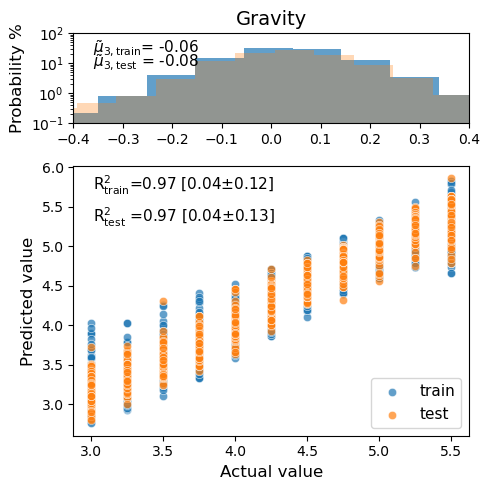

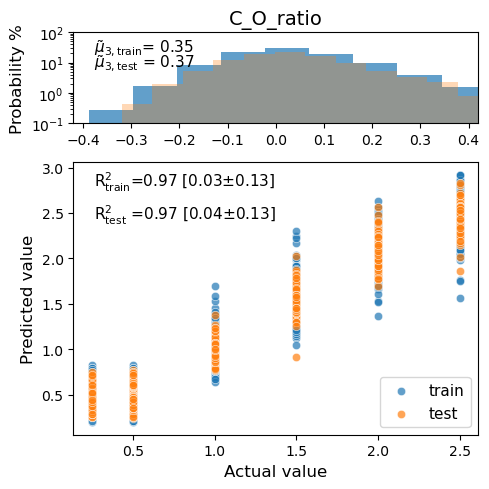

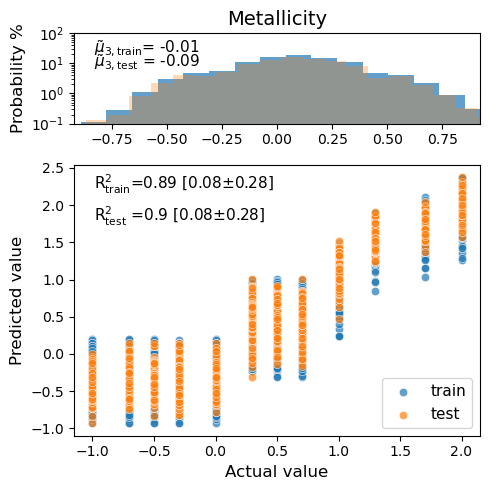

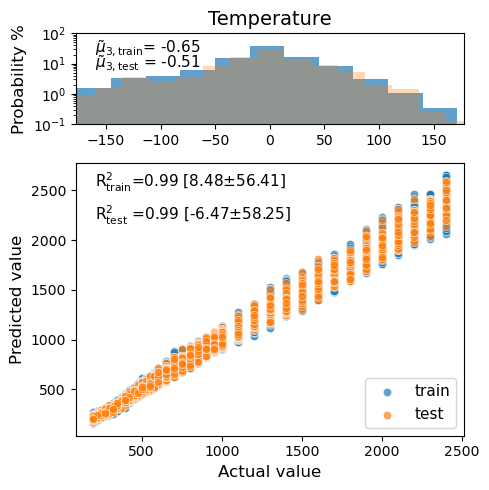

In [41]:
i = 1
regression_report(
        trained_model = train_cnn_regression,
    
        Xtrain = [train_cnn_regression.X_train_standardized_rowwise[::i],
                  train_cnn_regression.X_train_standardized_columnwise[::i]],
    
        Xtest  = [train_cnn_regression.X_test_standardized_rowwise[::i], 
                  train_cnn_regression.X_test_standardized_columnwise[::i]],
    
        ytrain = train_cnn_regression.y_train_standardized_columnwise[::i],
    
        ytest  = train_cnn_regression.y_test_standardized_columnwise[::i],
    
        target_i = 4,
        
        xy_top   = [0.05, 0.7],
        xy_bottom= [0.05, 0.85],
        print_results = False,        
                 )